# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import requests
import numpy as np
import os
import pandas as pd
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
 # to plot graph
import matplotlib.pyplot as plt                                     
plt.rc("font", size=14)
%matplotlib inline
from matplotlib import cm as cm
# for intractve graphs
import seaborn as sns                                                
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.filterwarnings('ignore')

archive_df = pd.read_csv('twitter-archive-enhanced.csv')
archive_df.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [2]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

folder_name = 'image-predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
with open('image_predictions.tsv', mode='wb') as file:
    file.write(response.content)
    
image_prediction = pd.read_csv('image_predictions.tsv', sep='\t')
image_prediction.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [9]:
 image_prediction.duplicated().sum()

0

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [6]:
with open('tweet_json.txt') as f:
    twitter_api = pd.DataFrame((json.loads(line) for line in f), columns = ['id', 'favorite_count', 'retweet_count'])

# change column names
twitter_api.columns = ['tweet_id', 'favorites', 'retweets']
# use tweet id column as index
twitter_api.set_index('tweet_id', inplace = True)
# display few lines 
twitter_api.head()

,favorites,retweets
tweet_id,,
892420643555336193,39467,8853
892177421306343426,33819,6514
891815181378084864,25461,4328
891689557279858688,42908,8964
891327558926688256,41048,9774


In [8]:
twitter_api.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354 entries, 892420643555336193 to 666020888022790149
Data columns (total 2 columns):
favorites    2354 non-null int64
retweets     2354 non-null int64
dtypes: int64(2)
memory usage: 55.2 KB


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [7]:
# display sample of data
archive_df.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [10]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
archive_df[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [12]:
archive_df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [13]:
archive_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [14]:
archive_df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [15]:
archive_df.name.value_counts()

None              745
a                  55
Charlie            12
Oliver             11
Lucy               11
Cooper             11
Penny              10
Tucker             10
Lola               10
Bo                  9
Winston             9
the                 8
Sadie               8
Toby                7
Bailey              7
Buddy               7
Daisy               7
an                  7
Oscar               6
Scout               6
Bella               6
Jax                 6
Milo                6
Leo                 6
Koda                6
Stanley             6
Jack                6
Dave                6
Rusty               6
Sunny               5
                 ... 
Bookstore           1
Clybe               1
Kanu                1
Lipton              1
Covach              1
Reptar              1
Furzey              1
Mac                 1
Amber               1
Skittles            1
Brat                1
Strudel             1
Huxley              1
Dwight              1
Dixie     

### Quality issues
1. Drop columns not needed for analysis

2. Missing values in 'name' and dog stages represented as 'None'

3. Some records have more than on dog stage

4. Missing URLs in expanded_urls

5. Error in dog names (e.g a,an,actually) are not a dog's name

6. Some values in rating_numerator and rating_denominator seem to be in error or suspicious outliers.

7. Missing images

8. Missing tweets

### Tidiness issues
1. doggo, floofer, pupper and puppo columns in twitter_archive table should be merged into one column named "dog_stage"

2. Image predictions table should be added to twitter archuive table


## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [16]:
# Make copies of original pieces of data
archive_clean = archive_df.copy()
image_clean = image_prediction.copy()
twitterapi_clean = twitter_api.copy()


### Issue #1:

#### Define: Drop columns not needed for analysis

#### Code

In [17]:
archive_clean = archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp', 'expanded_urls'], 1)

#### Test

In [18]:
 archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null object
source                2356 non-null object
text                  2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
dtypes: int64(3), object(8)
memory usage: 202.5+ KB


### Issue #2:

#### Define: Missing values in 'name' and dog stages represented as 'None'

#### Code

In [19]:
archive_clean['name'][archive_clean['name'].str.match('[a-z]+')] = 'None'

#### Test

In [20]:
archive_clean.name.value_counts()

None              854
Charlie            12
Cooper             11
Lucy               11
Oliver             11
Penny              10
Lola               10
Tucker             10
Bo                  9
Winston             9
Sadie               8
Bailey              7
Buddy               7
Daisy               7
Toby                7
Stanley             6
Bella               6
Oscar               6
Jax                 6
Leo                 6
Rusty               6
Jack                6
Scout               6
Milo                6
Koda                6
Dave                6
Chester             5
Sammy               5
Sunny               5
Larry               5
                 ... 
Tripp               1
Willy               1
Gunner              1
Lucky               1
Kawhi               1
Lance               1
Oreo                1
Chuq                1
Dex                 1
Jerome              1
Mac                 1
Skittles            1
Brat                1
Strudel             1
Huxley    

### Issue #3:

#### Define: Some records have more than on dog stage

In [21]:
archive_clean['add_all'] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo
archive_clean.add_all.value_counts()

NoneNoneNoneNone        1976
NoneNonepupperNone       245
doggoNoneNoneNone         83
NoneNoneNonepuppo         29
doggoNonepupperNone       12
NoneflooferNoneNone        9
doggoflooferNoneNone       1
doggoNoneNonepuppo         1
Name: add_all, dtype: int64

In [22]:
def check_stages(archive):
    if archive['add_all'].count('None') == 2:
        return 'Multiple' #this means it has more than one dog stage
    else:
        if archive['add_all'].count('doggo') == 1:
            return 'Doggo'
        elif archive['add_all'].count('floofer') == 1:
            return 'Floofer'
        elif archive['add_all'].count('pupper') == 1:
            return 'Pupper'
        elif archive['add_all'].count('puppo') == 1:
            return 'Puppo'
        else:
            return 'None'

archive_clean['dog_stage'] = archive_clean.apply(check_stages, axis=1)

In [23]:
#Test
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null object
source                2356 non-null object
text                  2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
add_all               2356 non-null object
dog_stage             2356 non-null object
dtypes: int64(3), object(10)
memory usage: 239.4+ KB


## Issue #4

### define: Drop 'doggo', 'floofer', 'pupper', 'puppo', 'add_all' collum not in use

In [24]:
archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo', 'add_all'], axis=1, inplace=True)

In [25]:
archive_clean.dog_stage = archive_clean.dog_stage.astype('category')

In [26]:
#test
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null object
source                2356 non-null object
text                  2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
dog_stage             2356 non-null category
dtypes: category(1), int64(3), object(4)
memory usage: 131.4+ KB


## Issue #5

### define: Move twitter api table and image prediction table to twitter archive table.

In [28]:
archive_clean = pd.merge(left=archive_clean, right=twitterapi_clean, how='left', on='tweet_id')
archive_clean = pd.merge(left=archive_clean, right=image_clean, how='left', on='tweet_id')

In [29]:
#Test
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 21 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null object
source                2356 non-null object
text                  2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
dog_stage             2356 non-null category
favorites             2354 non-null float64
retweets              2354 non-null float64
jpg_url               2075 non-null object
img_num               2075 non-null float64
p1                    2075 non-null object
p1_conf               2075 non-null float64
p1_dog                2075 non-null object
p2                    2075 non-null object
p2_conf               2075 non-null float64
p2_dog                2075 non-null object
p3                    2075 non-null object
p3_conf               2075 non-null float64
p3_dog                2075 n

## Issue #6:

### define: Drop tweets with no images

In [30]:
archive_clean.dropna(axis = 0, inplace=True)

In [32]:
#Test
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2355
Data columns (total 21 columns):
tweet_id              2073 non-null int64
timestamp             2073 non-null object
source                2073 non-null object
text                  2073 non-null object
rating_numerator      2073 non-null int64
rating_denominator    2073 non-null int64
name                  2073 non-null object
dog_stage             2073 non-null category
favorites             2073 non-null float64
retweets              2073 non-null float64
jpg_url               2073 non-null object
img_num               2073 non-null float64
p1                    2073 non-null object
p1_conf               2073 non-null float64
p1_dog                2073 non-null object
p2                    2073 non-null object
p2_conf               2073 non-null float64
p2_dog                2073 non-null object
p3                    2073 non-null object
p3_conf               2073 non-null float64
p3_dog                2073 n

## Issue #7:

### define: Change datatypes

In [39]:
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)
archive_clean.dog_stage =archive_clean.dog_stage.astype("category")
archive_clean[['rating_numerator', 'rating_denominator']] =archive_clean[['rating_numerator', 'rating_denominator']].astype(float)
archive_clean.source = archive_clean.source.astype("category")
archive_clean.timestamp = pd.to_datetime(twitter_archive_master.timestamp)

In [40]:
#Test
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2355
Data columns (total 21 columns):
tweet_id              2073 non-null object
timestamp             1794 non-null datetime64[ns]
source                2073 non-null category
text                  2073 non-null object
rating_numerator      1794 non-null float64
rating_denominator    1794 non-null float64
name                  2073 non-null object
dog_stage             1794 non-null category
favorites             2073 non-null float64
retweets              2073 non-null float64
jpg_url               2073 non-null object
img_num               2073 non-null float64
p1                    2073 non-null object
p1_conf               2073 non-null float64
p1_dog                2073 non-null object
p2                    2073 non-null object
p2_conf               2073 non-null float64
p2_dog                2073 non-null object
p3                    2073 non-null object
p3_conf               2073 non-null float64
p3_dog       

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [41]:
archive_clean.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [42]:
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')
twitter_archive_master.info()
twitter_archive_master.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2073 entries, 0 to 2072
Data columns (total 21 columns):
tweet_id              1794 non-null float64
timestamp             1794 non-null object
source                2073 non-null object
text                  2073 non-null object
rating_numerator      1794 non-null float64
rating_denominator    1794 non-null float64
name                  2073 non-null object
dog_stage             1794 non-null object
favorites             2073 non-null float64
retweets              2073 non-null float64
jpg_url               2073 non-null object
img_num               2073 non-null float64
p1                    2073 non-null object
p1_conf               2073 non-null float64
p1_dog                2073 non-null bool
p2                    2073 non-null object
p2_conf               2073 non-null float64
p2_dog                2073 non-null bool
p3                    2073 non-null object
p3_conf               2073 non-null float64
p3_dog                2073 n

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,favorites,retweets,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,8.924206e+17,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,None,39467.0,8853.0,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,8.921774e+17,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,None,33819.0,6514.0,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,8.918152e+17,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,None,25461.0,4328.0,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,8.916896e+17,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13.0,10.0,Darla,None,42908.0,8964.0,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,8.913276e+17,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12.0,10.0,Franklin,None,41048.0,9774.0,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


### Insights:
1. Most popular dog name

2. Is there a correlation between Favorite and Retweet ?

3. Most used Twitter Source

### Visualization

## Most popular dog name

In [43]:
 pname = twitter_archive_master.name.value_counts()[1:10]

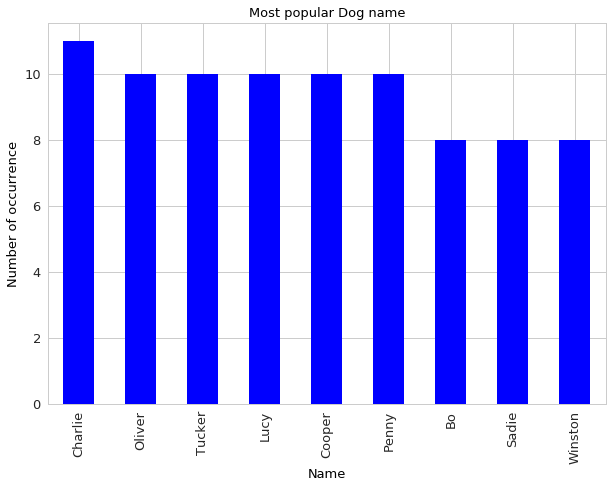

In [44]:
#plot
g_bar = pname.plot.bar(color = 'blue', fontsize = 13)

#figure size(width, height)
g_bar.figure.set_size_inches(10, 7);

#Add labels
plt.title('Most popular Dog name', color = 'black', fontsize = '13')
plt.xlabel('Name', color = 'black', fontsize = '13')
plt.ylabel('Number of occurrence', color = 'black', fontsize = '13');

 'Charlie' the most popular dog name 

## Is there a correlation between Favorite and Retweet ?

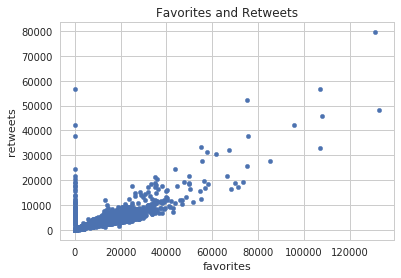

In [47]:
twitter_archive_master.plot(x='favorites', y='retweets', kind='scatter', title = 'Favorites and Retweets');

In [49]:
 twitter_archive_master['favorites'].corr(twitter_archive_master['retweets'])

0.79047607884450788

The scatter plot shows there is positive correlation between favorite and Retweet.

## Most used Twitter Source

In [52]:
source = twitter_archive_master['source'].value_counts()
source

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2032
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       30
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

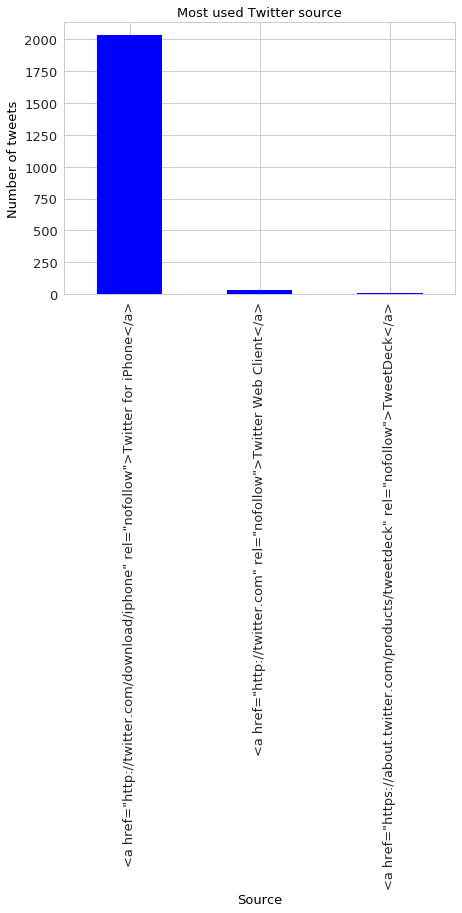

In [53]:
#plot
g_bar = source.plot.bar(color = 'blue', fontsize = 13)

#figure size(width, height)
g_bar.figure.set_size_inches(7, 5);

#Add labels
plt.title('Most used Twitter source', color = 'black', fontsize = '13')
plt.xlabel('Source', color = 'black', fontsize = '13')
plt.ylabel('Number of tweets', color = 'black', fontsize = '13');

Most used Twitter Source is Twitter from iPhone 